In [1]:
# Import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import kagglehub
import os

In [2]:
# Load the data
dataset_dir = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_csv(fr'{dataset_dir}/Combined Data.csv', index_col=0)

/home/tyler/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv


In [3]:
# Display the first few rows of the dataframe
print(df.head())

                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


In [4]:
# EDA
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


In [5]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
statement    362
status         0
dtype: int64


In [6]:
# Handle NaN values in the statement column
#df['statement'] = df['statement'].fillna('')
df = df.dropna(subset=['statement']).reset_index(drop=True)

In [7]:
# Text Length Distribution
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))
fig = px.histogram(df, x='text_length', title='Text Length Distribution')
fig.show()

In [8]:
# Data Preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to /home/tyler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tyler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tyler/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [10]:
# Data Augmentation

# The back translator
def augment_text(text, target_language='fr'):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to=target_language).translate(to='en')
        return str(translated)
    except Exception:
        return text

# Augments and stores the results in a new df 'augmented_statement'
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = augmented_df['statement'].apply(lambda x: augment_text(x, target_language='fr'))

# Dropna and apply preprocess on new augmented data
augmented_df = augmented_df.dropna(subset=['statement']).reset_index(drop=True)
augmented_df['cleaned_statement'] = augmented_df['statement'].apply(lambda x: remove_stopwords(preprocess_text(x)))

# Merge augmented data with the original (stack vertically)
df = pd.concat([df, augmented_df])

# Splitting the data
X = df['cleaned_statement']
y = df['status']

In [11]:
# 1. Load the pretrained BERT model and tokenizer
# Use the bert-base-uncased and add a custom classification head for 7 classes
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7) 

# If a GPU is availeble use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 2. BERT expects integers so encode to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y must be a 1D array of labels

# 3. Build custom dataset for tokenized texts
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize a single text array
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y_encoded, test_size=0.2, random_state=42)

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 5. Setup the optimizer
# AdamW is a standard optimizer for fine-tuning transformers
optimizer = AdamW(model.parameters(), lr=2e-5)

# 6. Training loop
epochs = 3

# Loop over the dataset multiple times
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    # Loop over each mini-batch from the training DataLoader
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

# 7. Evaluation
model.eval() # Sets the model to Evaluation mode 
all_preds = []
all_labels = []

# No gradient tracking
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        
        # Collect the predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# 8. Print classification report
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Loss: 0.5547
Epoch 2 - Loss: 0.3077
Epoch 3 - Loss: 0.1700
                      precision    recall  f1-score   support

             Anxiety       0.95      0.96      0.96      1523
             Bipolar       0.97      0.94      0.96      1109
          Depression       0.92      0.88      0.90      6204
              Normal       0.98      0.97      0.98      6505
Personality disorder       0.97      0.90      0.93       424
              Stress       0.88      0.92      0.90      1080
            Suicidal       0.84      0.91      0.87      4228

            accuracy                           0.92     21073
           macro avg       0.93      0.92      0.93     21073
        weighted avg       0.93      0.92      0.92     21073



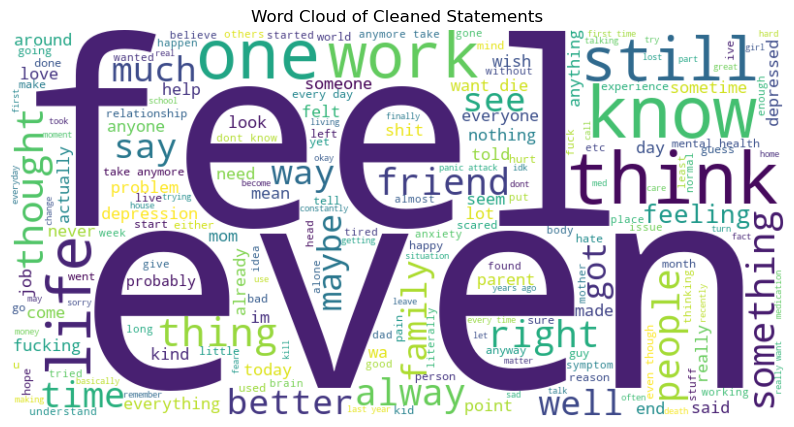

In [12]:
# Summarize good data

# Class 'Status' Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.show()

# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()

In [13]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Vectorization: Convert text values to numeric values for calculation
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [15]:
# Model Training with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

In [16]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [17]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'C': 100}
Accuracy Score:
0.8807004223413847
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.94      0.94      0.94      1523
             Bipolar       0.95      0.95      0.95      1109
          Depression       0.84      0.83      0.83      6204
              Normal       0.96      0.97      0.96      6505
Personality disorder       0.96      0.95      0.95       424
              Stress       0.93      0.90      0.91      1080
            Suicidal       0.77      0.77      0.77      4228

            accuracy                           0.88     21073
           macro avg       0.91      0.90      0.90     21073
        weighted avg       0.88      0.88      0.88     21073



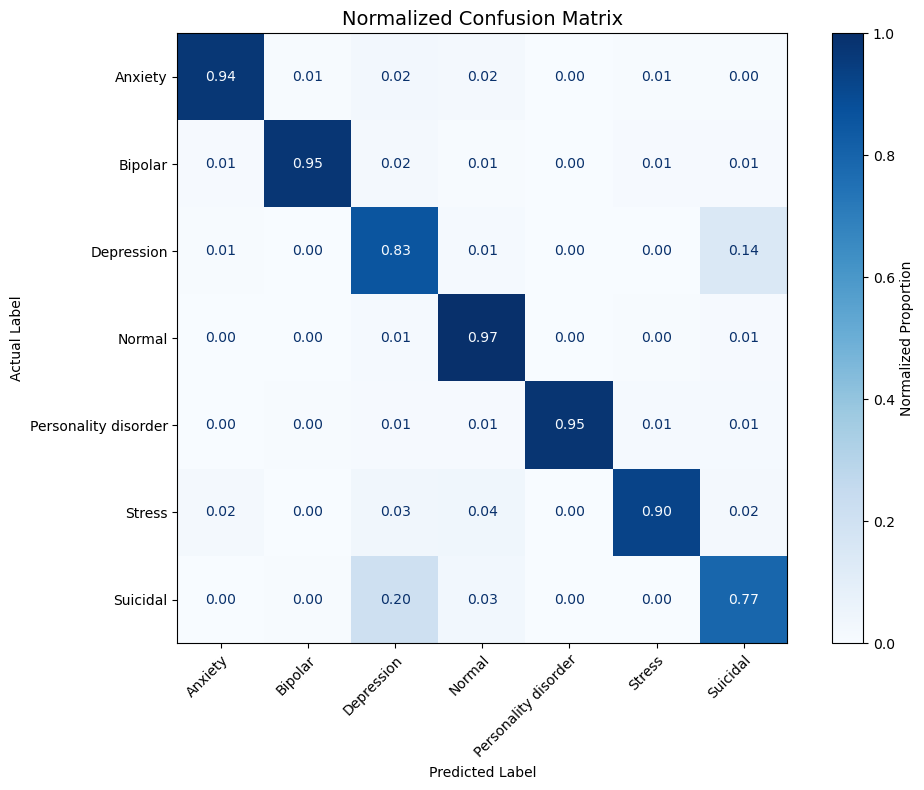

In [18]:
# Compute normalized confusion matrix
labels = sorted(set(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f", colorbar=False)

# Colorbar with full range from 0 to 1
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Normalized Proportion')
cbar.set_ticks(np.linspace(0, 1, 6))
cbar.ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)])

# Label formatting
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Titles and axis labels
ax.set_title("Normalized Confusion Matrix", fontsize=14)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")

plt.tight_layout()
plt.show()

In [19]:
# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_
for i, category in enumerate(best_model.classes_):
    top_features = coefs[i].argsort()[-10:]
    top_words = [feature_names[j] for j in top_features]
    top_scores = [coefs[i][j] for j in top_features]
    fig = go.Figure([go.Bar(x=top_words, y=top_scores)])
    fig.update_layout(title=f'Top Features for {category}')
    fig.show()